<a href="https://colab.research.google.com/github/eormeno12/CursoIntroduccionAlML/blob/5.Reconocimiento_de_im%C3%A1genes/5_Reconocimiento_de_im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Construyendo un modelo

---



In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt

In [47]:
data_path = "data/"
transform = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                              ])

full_dataset = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
full_validation_set = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Establecemos un **data loader** para cargar los datos en un tamaño.

Por ejemplo, si establecemos el tamaño en 4, cada batch va a ser de 4 imágenes.

Trabajamos con batch cuando el dataset es muy grande y precisamos de trabajar con muestras para reducir el consumo de hardware.

In [48]:
size = 4
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=size, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat
car
dog
bird


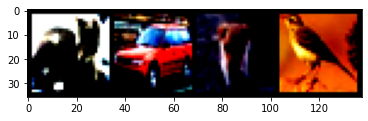

In [49]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck'] 

plt.imshow(utils.make_grid(imgs).permute(1, 2, 0))

for i in range(size):
  print(classes[labels[i]])

####Implementando un clasificador binario

Separamos el datset en solo carros y gatos.

In [50]:
label_map = {1:0, 3:1}
classes_name = ["car", "cat"]

data_set = [(img, label_map[label]) for img, label in full_dataset if label in [1, 3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1, 3]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('cat',
 torch.Size([3, 32, 32]))

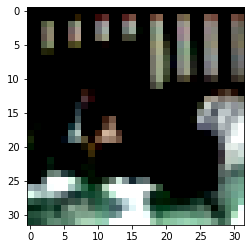

In [51]:
img, label = data_set[40]
classes_name[label], plt.imshow(img.permute(1, 2, 0)), img.shape

Creamos un modelo que recibe **3 * 32 * 32** que es el shape o cantidad de datos que tiene el tensor de la imagen 3 32 32.

Posteriormente aplicamos una función de activación neuronal para que se pueda comunicar con el siguiente linear.

**Softmax** posee limitantes.

Para evitar cambios bruscos entre neuronas, lo que buscamos es crear más y llegar poco a poco al objetivo.

In [52]:
model = nn.Sequential(
    #nn.Linear(3*32*32, 512),

    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    
    #nn.Softmax(dim=1)
    #nn.LogSoftmax(dim = 1)
)

El **nn.NLLLoss() + nn.Softmax()** tiene un efecto que deriva en **nn.CrossEntropyLoss()**.


In [53]:
#loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.1857, 0.0523]], grad_fn=<AddmmBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'cat'

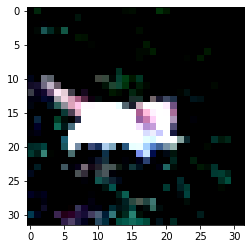

In [54]:
img, label = data_set[10]
plt.imshow(img.permute(1, 2, 0))
classes_name[label]

In [55]:
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.1004, 0.0350]], grad_fn=<AddmmBackward>)

Entrenamiento del model

In [56]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
n_epochs = 100
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [57]:
for epoch in range(n_epochs):
  for img, label in train_loader:
    out = model(img.view(img.shape[0], -1))
    loss = loss_function(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch}, Loss: {float(loss)}")

Epoch: 0, Loss: 0.6660740971565247
Epoch: 1, Loss: 0.46768033504486084
Epoch: 2, Loss: 0.5943935513496399
Epoch: 3, Loss: 0.38616013526916504
Epoch: 4, Loss: 0.929726779460907
Epoch: 5, Loss: 0.3092668950557709
Epoch: 6, Loss: 0.1381336748600006
Epoch: 7, Loss: 0.29648274183273315
Epoch: 8, Loss: 0.37965208292007446
Epoch: 9, Loss: 0.22980524599552155
Epoch: 10, Loss: 0.37205636501312256
Epoch: 11, Loss: 0.17986202239990234
Epoch: 12, Loss: 0.2719612419605255
Epoch: 13, Loss: 0.6013038754463196
Epoch: 14, Loss: 0.06372466683387756
Epoch: 15, Loss: 0.21440455317497253
Epoch: 16, Loss: 0.153592050075531
Epoch: 17, Loss: 0.15060310065746307
Epoch: 18, Loss: 0.03877834230661392
Epoch: 19, Loss: 0.4462328553199768
Epoch: 20, Loss: 0.07346244901418686
Epoch: 21, Loss: 0.2547755241394043
Epoch: 22, Loss: 0.07648570090532303
Epoch: 23, Loss: 0.027489416301250458
Epoch: 24, Loss: 0.07543426007032394
Epoch: 25, Loss: 0.3048991560935974
Epoch: 26, Loss: 0.06826464086771011
Epoch: 27, Loss: 0.0291

Podemos ver que el modelo funciona de manera óptima con el set de validación con un acurency del **85.8%** e incluso de un **100%** con el de train, pero uno debe de tener cuidado cuando se topa con la perfección del 100% porque eso significa que nuestras neuronas lo que han hecho es memorizar los datos.

Acuracy con el set de validación.

In [62]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in val_loader:
    outputs = model(imgs.view(imgs.shape[0], -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]

    correct += int((predicted == labels).sum())

print(f"Accuracy: {correct/total}")

Accuracy: 0.858


Acuracy con el training set.

In [63]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in train_loader:
    outputs = model(imgs.view(imgs.shape[0], -1))
    _, predicted = torch.max(outputs, dim=1)
    total += labels.shape[0]

    correct += int((predicted == labels).sum())

print(f"Accuracy: {correct/total}")

Accuracy: 1.0


In [64]:
img, label = data_set[500]
out = model(img.view(-1).unsqueeze(0))
out

tensor([[ 3.3742, -3.1876]], grad_fn=<AddmmBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model -> car, Real -> car


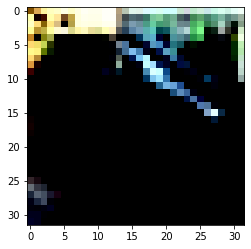

In [65]:
_, predicted = torch.max(out, dim=1)
print(f"Model -> {classes_name[predicted]}, Real -> {classes_name[label]}")
plt.imshow(img.permute(1, 2, 0))

Número de parámetros del model.

In [66]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

###Prueba del modelo con una imagen ajena al dataset

In [76]:
image = request.urlretrieve("https://kolyan.net/uploads/posts/2009-11/1257956414_cat-car.jpg")
img = Image.open(image[0])

preprocces = transforms.Compose([
  transforms.Resize(32),
  transforms.CenterCrop(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model -> car, Real -> car


tensor([[ 0.0256, -0.0183]], grad_fn=<AddmmBackward>)

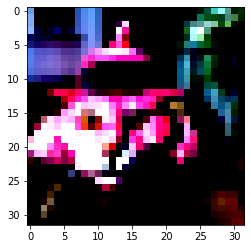

In [78]:
img_transformed = preprocces(img)

out = model(img_transformed.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print(f"Model -> {classes_name[index]}, Real -> car")
plt.imshow(img_transformed.permute(1, 2, 0))
out

En esta ocasión, el modelo funcionó, pero pueden darse circunstacias en donde el modelo en vez de detectar un carro, detecte un gato. Este tipo de errores se pueden dar por culpa del modelo o a causa de un mal resize de la imagen.